# Practical Work

In [1]:
import pandas as pd

## Create the dataset files for RecBole

### Dataset structure
Recbole knowledge aware datasets require three files: .inter, .g, .link files. 

| File | Description |
|------|-------------|
|.inter|User-Item interaction|
|.kg| head, relation, tail|
|.link|item_id to entity_id|

## Create atomic files

 Add type info to kg generated by David

In [2]:
dataset = '10percent_subset'
path = 'data/lfm'
kg_path = '%s/intermediate_kg/%s' % (path, dataset)
prefixed_path = '%s/%s' % (path,dataset)

In [3]:
kg = pd.read_csv('%s_kg.txt' % kg_path, sep='\t', names=['head_id:token', 'relation_id:token', 'tail_id:token'])

In [4]:
kg.head()

,head_id:token,relation_id:token,tail_id:token
0,t36346257,in_album,b13466481
1,t28579456,in_album,b15155822
2,t24710513,in_album,b11443173
3,t41502757,in_album,b15403971
4,t44589417,in_album,b21041179


In [5]:
kg['relation_id:token'].unique()

array(['in_album', 'has_genre', 'created_by', 'has_gender',
       'has_micro_genre', 'listened_to', 'lives_in'], dtype=object)

In [6]:
kg_no_listen_events = kg[kg['relation_id:token'] != 'listened_to']
kg_no_listen_events.to_csv('data/rb_lfm/rb_lfm.kg', sep='\t', index=False)

In [7]:
users = pd.read_csv('%s_users.tsv' % prefixed_path, sep='\t', skiprows=[0], names=['user_id:token', 'country:token', 'age:token', 'gender:token', 'creation_time:token'])
users.to_csv('data/rb_lfm/rb_lfm.user', sep='\t', index=False)

In [8]:
items = pd.read_csv('%s_tracks.tsv' % prefixed_path, sep='\t', skiprows=[0], names=['item_id:token', 'artist:token', 'track:token'])
items.to_csv('data/rb_lfm/rb_lfm.item', sep='\t', index=False)
                    
track_ids = pd.DataFrame(items['item_id:token'])
track_ids['entity_id:token'] = 't' + track_ids['item_id:token'].astype(str)
track_ids.to_csv('data/rb_lfm/rb_lfm.link', sep='\t', index=False)

In [9]:
listening_events = pd.read_csv('%s_listening_events.tsv' % prefixed_path, sep='\t', skiprows=[0], names=['user_id:token', 'item_id:token', 'album_id:token', 'timestamp:token'])
listening_events.to_csv('data/rb_lfm/rb_lfm.inter', sep='\t', index=False)

In [10]:
# free memory
del kg
del kg_no_listen_events
del items
del track_ids
del users
del listening_events

## Demo run model

In [11]:
#from recbole.quick_start import run_recbole
#run_recbole(model='KGAT', dataset='rb_lfm', config_file_list=['lfm.yaml'])

# Custom pipeline

### Load config and create Dataset

In [1]:
from logging import getLogger
from recbole.config import Config
from recbole.data import create_dataset, data_preparation
from recbole.model.knowledge_aware_recommender import KGAT
from recbole.trainer import KGATTrainer
from recbole.utils import init_seed, init_logger

In [61]:

# configurations initialization
config = Config(model='KGAT', dataset='rb_lfm', config_file_list=['lfm.yaml'])

# init random seed
init_seed(config['seed'], config['reproducibility'])

# logger initialization
init_logger(config)
logger = getLogger()

# write config info into log
logger.info(config)

# dataset creating and filtering
dataset = create_dataset(config)
logger.info(dataset)

# dataset splitting
train_data, valid_data, test_data = data_preparation(config, dataset)


20 Feb 07:46    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 2020
state = INFO
reproducibility = True
data_path = ./data/rb_lfm
checkpoint_dir = saved
show_progress = True
save_dataset = False
dataset_save_path = None
save_dataloaders = False
dataloaders_save_path = None
log_wandb = False

Training Hyper Parameters:
epochs = 100
train_batch_size = 256
learner = adam
learning_rate = 0.001
train_neg_sample_args = {'distribution': 'uniform', 'sample_num': 1, 'alpha': 1.0, 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [8, 1, 1]}, 'group_by': 'user', 'order': 'RO', 'mode': 'full'}
repeatable = False
metrics = ['NDCG', 'Hit', 'Precision']
topk = [10]
valid_metric = NDCG@10
valid_metric_bigger = True
eval_batch_size = 256
metric_decimal_place = 4

Dataset Hyper Parameters:
field_separator = 	
seq_separator =  
USER_ID_FIELD = 

In [14]:
len(train_data)

5060

### Train model and evaluate

In [15]:
# model loading and initialization
model = KGAT(config, train_data._dataset).to(config['device'])
logger.info(model)

# trainer loading and initialization
trainer = KGATTrainer(config, model)

print('Starting to fit model')
# model training
best_valid_score, best_valid_result = trainer.fit(train_data, valid_data, saved=True, show_progress=True)

print('Evaluating model')
# model evaluation
test_result = trainer.evaluate(test_data, load_best_model=True)
print(test_result)

/home/jfallmann/miniconda3/envs/pr/lib/python3.9/site-packages/dgl/subgraph.py:288: DGLWarning: Key word argument preserve_nodes is deprecated. Use relabel_nodes instead.
  dgl_warning(
/home/jfallmann/miniconda3/envs/pr/lib/python3.9/site-packages/recbole/model/knowledge_aware_recommender/kgat.py:159: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -1).flatten()
/home/jfallmann/miniconda3/envs/pr/lib/python3.9/site-packages/recbole/model/knowledge_aware_recommender/kgat.py:166: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/torch/csrc/utils/tensor_new.cpp:230.)
  indices = torch.LongTensor([final_adj_matrix.row, final_adj_matrix.col])
19 Feb 16:22    INFO  KGAT(
  (user_embedding): Embedding(14415, 32)
  (entity_embedding): Embedding(232413

Starting to fit model


Train     0:   0%|          | 0/5060 [00:00<?, ?it/s]

Train     0:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 16:28    INFO  epoch 0 training [time: 386.68s, train_loss1: 1543.3758, train_loss2: 385.0037]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 16:29    INFO  epoch 0 evaluating [time: 23.09s, valid_score: 0.020100]
19 Feb 16:29    INFO  valid result: 
ndcg@10 : 0.0201    hit@10 : 0.1142    precision@10 : 0.0137
19 Feb 16:29    INFO  Saving current: saved/KGAT-Feb-19-2023_16-22-11.pth


Train     1:   0%|          | 0/5060 [00:00<?, ?it/s]

Train     1:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 16:34    INFO  epoch 1 training [time: 328.45s, train_loss1: 1157.6003, train_loss2: 157.9358]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 16:34    INFO  epoch 1 evaluating [time: 23.25s, valid_score: 0.041800]
19 Feb 16:34    INFO  valid result: 
ndcg@10 : 0.0418    hit@10 : 0.2048    precision@10 : 0.0276
19 Feb 16:34    INFO  Saving current: saved/KGAT-Feb-19-2023_16-22-11.pth


Train     2:   0%|          | 0/5060 [00:00<?, ?it/s]

Train     2:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 16:40    INFO  epoch 2 training [time: 327.70s, train_loss1: 829.9228, train_loss2: 87.7527]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 16:40    INFO  epoch 2 evaluating [time: 23.23s, valid_score: 0.044800]
19 Feb 16:40    INFO  valid result: 
ndcg@10 : 0.0448    hit@10 : 0.2176    precision@10 : 0.0293
19 Feb 16:40    INFO  Saving current: saved/KGAT-Feb-19-2023_16-22-11.pth


Train     3:   0%|          | 0/5060 [00:00<?, ?it/s]

Train     3:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 16:46    INFO  epoch 3 training [time: 328.27s, train_loss1: 647.0201, train_loss2: 57.7524]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 16:46    INFO  epoch 3 evaluating [time: 23.04s, valid_score: 0.047400]
19 Feb 16:46    INFO  valid result: 
ndcg@10 : 0.0474    hit@10 : 0.2275    precision@10 : 0.0315
19 Feb 16:46    INFO  Saving current: saved/KGAT-Feb-19-2023_16-22-11.pth


Train     4:   0%|          | 0/5060 [00:00<?, ?it/s]

Train     4:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 16:52    INFO  epoch 4 training [time: 328.32s, train_loss1: 526.0126, train_loss2: 42.0258]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 16:52    INFO  epoch 4 evaluating [time: 23.32s, valid_score: 0.050700]
19 Feb 16:52    INFO  valid result: 
ndcg@10 : 0.0507    hit@10 : 0.2381    precision@10 : 0.0336
19 Feb 16:52    INFO  Saving current: saved/KGAT-Feb-19-2023_16-22-11.pth


Train     5:   0%|          | 0/5060 [00:00<?, ?it/s]

Train     5:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 16:57    INFO  epoch 5 training [time: 328.39s, train_loss1: 439.4339, train_loss2: 33.9963]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 16:58    INFO  epoch 5 evaluating [time: 23.48s, valid_score: 0.055300]
19 Feb 16:58    INFO  valid result: 
ndcg@10 : 0.0553    hit@10 : 0.2545    precision@10 : 0.037
19 Feb 16:58    INFO  Saving current: saved/KGAT-Feb-19-2023_16-22-11.pth


Train     6:   0%|          | 0/5060 [00:00<?, ?it/s]

Train     6:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 17:03    INFO  epoch 6 training [time: 327.71s, train_loss1: 377.6571, train_loss2: 28.1954]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 17:04    INFO  epoch 6 evaluating [time: 23.19s, valid_score: 0.058200]
19 Feb 17:04    INFO  valid result: 
ndcg@10 : 0.0582    hit@10 : 0.2589    precision@10 : 0.038
19 Feb 17:04    INFO  Saving current: saved/KGAT-Feb-19-2023_16-22-11.pth


Train     7:   0%|          | 0/5060 [00:00<?, ?it/s]

Train     7:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 17:09    INFO  epoch 7 training [time: 327.74s, train_loss1: 332.8999, train_loss2: 22.1535]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 17:10    INFO  epoch 7 evaluating [time: 23.32s, valid_score: 0.059200]
19 Feb 17:10    INFO  valid result: 
ndcg@10 : 0.0592    hit@10 : 0.265    precision@10 : 0.0392
19 Feb 17:10    INFO  Saving current: saved/KGAT-Feb-19-2023_16-22-11.pth


Train     8:   0%|          | 0/5060 [00:00<?, ?it/s]

Train     8:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 17:15    INFO  epoch 8 training [time: 328.53s, train_loss1: 299.0575, train_loss2: 19.8242]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 17:15    INFO  epoch 8 evaluating [time: 23.15s, valid_score: 0.059600]
19 Feb 17:15    INFO  valid result: 
ndcg@10 : 0.0596    hit@10 : 0.2663    precision@10 : 0.0399
19 Feb 17:15    INFO  Saving current: saved/KGAT-Feb-19-2023_16-22-11.pth


Train     9:   0%|          | 0/5060 [00:00<?, ?it/s]

Train     9:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 17:21    INFO  epoch 9 training [time: 327.64s, train_loss1: 273.1250, train_loss2: 17.2181]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 17:21    INFO  epoch 9 evaluating [time: 23.52s, valid_score: 0.062000]
19 Feb 17:21    INFO  valid result: 
ndcg@10 : 0.062    hit@10 : 0.2721    precision@10 : 0.0411
19 Feb 17:21    INFO  Saving current: saved/KGAT-Feb-19-2023_16-22-11.pth


Train    10:   0%|          | 0/5060 [00:00<?, ?it/s]

Train    10:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 17:27    INFO  epoch 10 training [time: 328.59s, train_loss1: 249.6307, train_loss2: 15.9242]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 17:27    INFO  epoch 10 evaluating [time: 23.60s, valid_score: 0.064100]
19 Feb 17:27    INFO  valid result: 
ndcg@10 : 0.0641    hit@10 : 0.28    precision@10 : 0.0423
19 Feb 17:27    INFO  Saving current: saved/KGAT-Feb-19-2023_16-22-11.pth


Train    11:   0%|          | 0/5060 [00:00<?, ?it/s]

Train    11:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 17:33    INFO  epoch 11 training [time: 328.00s, train_loss1: 227.9324, train_loss2: 13.5901]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 17:33    INFO  epoch 11 evaluating [time: 23.56s, valid_score: 0.063800]
19 Feb 17:33    INFO  valid result: 
ndcg@10 : 0.0638    hit@10 : 0.2772    precision@10 : 0.0431


Train    12:   0%|          | 0/5060 [00:00<?, ?it/s]

Train    12:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 17:38    INFO  epoch 12 training [time: 328.38s, train_loss1: 211.5258, train_loss2: 12.9510]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 17:39    INFO  epoch 12 evaluating [time: 25.06s, valid_score: 0.066600]
19 Feb 17:39    INFO  valid result: 
ndcg@10 : 0.0666    hit@10 : 0.2833    precision@10 : 0.0443
19 Feb 17:39    INFO  Saving current: saved/KGAT-Feb-19-2023_16-22-11.pth


Train    13:   0%|          | 0/5060 [00:00<?, ?it/s]

Train    13:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 17:44    INFO  epoch 13 training [time: 333.34s, train_loss1: 199.1794, train_loss2: 12.2507]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 17:45    INFO  epoch 13 evaluating [time: 24.88s, valid_score: 0.068900]
19 Feb 17:45    INFO  valid result: 
ndcg@10 : 0.0689    hit@10 : 0.2907    precision@10 : 0.0458
19 Feb 17:45    INFO  Saving current: saved/KGAT-Feb-19-2023_16-22-11.pth


Train    14:   0%|          | 0/5060 [00:00<?, ?it/s]

Train    14:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 17:50    INFO  epoch 14 training [time: 335.41s, train_loss1: 188.1607, train_loss2: 11.8535]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 17:51    INFO  epoch 14 evaluating [time: 23.25s, valid_score: 0.070500]
19 Feb 17:51    INFO  valid result: 
ndcg@10 : 0.0705    hit@10 : 0.2946    precision@10 : 0.0471
19 Feb 17:51    INFO  Saving current: saved/KGAT-Feb-19-2023_16-22-11.pth


Train    15:   0%|          | 0/5060 [00:00<?, ?it/s]

Train    15:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 17:56    INFO  epoch 15 training [time: 328.54s, train_loss1: 176.8538, train_loss2: 10.8281]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 17:57    INFO  epoch 15 evaluating [time: 23.46s, valid_score: 0.072200]
19 Feb 17:57    INFO  valid result: 
ndcg@10 : 0.0722    hit@10 : 0.3014    precision@10 : 0.0482
19 Feb 17:57    INFO  Saving current: saved/KGAT-Feb-19-2023_16-22-11.pth


Train    16:   0%|          | 0/5060 [00:00<?, ?it/s]

Train    16:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 18:02    INFO  epoch 16 training [time: 328.20s, train_loss1: 170.4832, train_loss2: 10.6014]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 18:03    INFO  epoch 16 evaluating [time: 23.34s, valid_score: 0.073800]
19 Feb 18:03    INFO  valid result: 
ndcg@10 : 0.0738    hit@10 : 0.301    precision@10 : 0.0487
19 Feb 18:03    INFO  Saving current: saved/KGAT-Feb-19-2023_16-22-11.pth


Train    17:   0%|          | 0/5060 [00:00<?, ?it/s]

Train    17:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 18:08    INFO  epoch 17 training [time: 331.08s, train_loss1: 161.9533, train_loss2: 10.0598]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 18:09    INFO  epoch 17 evaluating [time: 23.42s, valid_score: 0.074400]
19 Feb 18:09    INFO  valid result: 
ndcg@10 : 0.0744    hit@10 : 0.3012    precision@10 : 0.049
19 Feb 18:09    INFO  Saving current: saved/KGAT-Feb-19-2023_16-22-11.pth


Train    18:   0%|          | 0/5060 [00:00<?, ?it/s]

Train    18:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 18:14    INFO  epoch 18 training [time: 338.24s, train_loss1: 153.8182, train_loss2: 9.0637]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 18:15    INFO  epoch 18 evaluating [time: 25.19s, valid_score: 0.075900]
19 Feb 18:15    INFO  valid result: 
ndcg@10 : 0.0759    hit@10 : 0.3071    precision@10 : 0.0503
19 Feb 18:15    INFO  Saving current: saved/KGAT-Feb-19-2023_16-22-11.pth


Train    19:   0%|          | 0/5060 [00:00<?, ?it/s]

Train    19:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 18:20    INFO  epoch 19 training [time: 335.22s, train_loss1: 146.7094, train_loss2: 9.0514]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 18:21    INFO  epoch 19 evaluating [time: 23.73s, valid_score: 0.077200]
19 Feb 18:21    INFO  valid result: 
ndcg@10 : 0.0772    hit@10 : 0.311    precision@10 : 0.0509
19 Feb 18:21    INFO  Saving current: saved/KGAT-Feb-19-2023_16-22-11.pth


Train    20:   0%|          | 0/5060 [00:00<?, ?it/s]

Train    20:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 18:26    INFO  epoch 20 training [time: 331.85s, train_loss1: 144.6601, train_loss2: 9.4500]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 18:26    INFO  epoch 20 evaluating [time: 23.56s, valid_score: 0.078300]
19 Feb 18:26    INFO  valid result: 
ndcg@10 : 0.0783    hit@10 : 0.3151    precision@10 : 0.0518
19 Feb 18:26    INFO  Saving current: saved/KGAT-Feb-19-2023_16-22-11.pth


Train    21:   0%|          | 0/5060 [00:00<?, ?it/s]

Train    21:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 18:32    INFO  epoch 21 training [time: 329.11s, train_loss1: 136.2923, train_loss2: 9.0009]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 18:32    INFO  epoch 21 evaluating [time: 23.51s, valid_score: 0.080200]
19 Feb 18:32    INFO  valid result: 
ndcg@10 : 0.0802    hit@10 : 0.3201    precision@10 : 0.053
19 Feb 18:32    INFO  Saving current: saved/KGAT-Feb-19-2023_16-22-11.pth


Train    22:   0%|          | 0/5060 [00:00<?, ?it/s]

Train    22:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 18:38    INFO  epoch 22 training [time: 328.67s, train_loss1: 131.7865, train_loss2: 8.3898]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 18:38    INFO  epoch 22 evaluating [time: 23.36s, valid_score: 0.082700]
19 Feb 18:38    INFO  valid result: 
ndcg@10 : 0.0827    hit@10 : 0.3256    precision@10 : 0.0548
19 Feb 18:38    INFO  Saving current: saved/KGAT-Feb-19-2023_16-22-11.pth


Train    23:   0%|          | 0/5060 [00:00<?, ?it/s]

Train    23:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 18:44    INFO  epoch 23 training [time: 329.06s, train_loss1: 127.1996, train_loss2: 8.0747]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 18:44    INFO  epoch 23 evaluating [time: 23.70s, valid_score: 0.082400]
19 Feb 18:44    INFO  valid result: 
ndcg@10 : 0.0824    hit@10 : 0.3275    precision@10 : 0.0548


Train    24:   0%|          | 0/5060 [00:00<?, ?it/s]

Train    24:   0%|          | 0/2245 [00:00<?, ?it/s]

19 Feb 18:50    INFO  epoch 24 training [time: 329.19s, train_loss1: 123.6773, train_loss2: 7.6397]


Evaluate   :   0%|                                                        | 0/13776 [00:00<?, ?it/s…

19 Feb 18:50    INFO  epoch 24 evaluating [time: 24.17s, valid_score: 0.082100]
19 Feb 18:50    INFO  valid result: 
ndcg@10 : 0.0821    hit@10 : 0.3208    precision@10 : 0.054


Train    25:   0%|          | 0/5060 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
test_result = trainer.evaluate(test_data, load_best_model=True)
print(test_result)

# Load best model

In [3]:
import os
import torch

In [4]:
latest_model = 'saved/%s' % os.listdir('saved')[-1]

In [5]:
latest_model

'saved/KGAT-Feb-19-2023_16-22-11.pth'

In [6]:
state_dict = torch.load(latest_model, map_location='cuda')
model = KGAT(config, train_data._dataset).to(config['device'])

model.load_state_dict(state_dict['state_dict'])

/home/jfallmann/miniconda3/envs/pr/lib/python3.9/site-packages/dgl/subgraph.py:288: DGLWarning: Key word argument preserve_nodes is deprecated. Use relabel_nodes instead.
  dgl_warning(
/home/jfallmann/miniconda3/envs/pr/lib/python3.9/site-packages/recbole/model/knowledge_aware_recommender/kgat.py:159: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -1).flatten()
/home/jfallmann/miniconda3/envs/pr/lib/python3.9/site-packages/recbole/model/knowledge_aware_recommender/kgat.py:166: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/torch/csrc/utils/tensor_new.cpp:230.)
  indices = torch.LongTensor([final_adj_matrix.row, final_adj_matrix.col])


<All keys matched successfully>

## Some model investigation

The model contains entity and user embeddings

In [7]:
model.entity_embedding.weight.shape

torch.Size([232413, 32])

Ego Embeddings return current user and entity embeddings and concatenates them

In [8]:
ego_embeddings = model._get_ego_embeddings()
ego_embeddings.shape

torch.Size([246828, 32])

In [9]:
from recbole.data.interaction import Interaction
input_interactions = Interaction({
    'user_id': torch.tensor([1]),
    'item_id_list': torch.tensor([]),
    'item_length': torch.tensor([])
})
predictions = model.full_sort_predict(input_interactions)

In [10]:
predictions.shape

torch.Size([100023])

In [11]:
dataset

rb_lfm
The number of users: 14415
Average actions of users: 111.45067295684751
The number of items: 100023
Average actions of items: 16.060966587350784
The number of inters: 1606450
The sparsity of the dataset: 99.88858268460203%
Remain Fields: ['entity_id', 'user_id', 'item_id', 'timestamp', 'head_id', 'relation_id', 'tail_id', 'neg_item_id', 'neg_tail_id']
The number of entities: 232413
The number of relations: 8
The number of triples: 574630
The number of items that have been linked to KG: 100022

## The attention matrix

The attention matrix is a nxn matrix where $n = n_u + n_e$ with $n_u$ being the number of users and $n_e$ the number of entities

The rows of the matrix indicate the head, the columns the tail and the values are the $\pi(h,r,t)$ values stated in the paper as

$$
\pi(h,r,t) = 
$$

So the attention matrix is more or less a graph with all relations and the corresponding attention value for a connection between head and tail.

In [12]:
attention_matrix = model.A_in

In [13]:
attention_matrix

tensor(indices=tensor([[     1,      1,      1,  ..., 129236, 129237, 129238],
                       [ 14416,  14536,  14888,  ..., 246745, 246679, 246682]]),
       values=tensor([0.0069, 0.0069, 0.0069,  ..., 1.0000, 1.0000, 1.0000]),
       device='cuda:0', size=(246828, 246828), nnz=1914618,
       layout=torch.sparse_coo)

In [14]:
attention_matrix.coalesce()

tensor(indices=tensor([[     1,      1,      1,  ..., 129236, 129237, 129238],
                       [ 14416,  14536,  14888,  ..., 246745, 246679, 246682]]),
       values=tensor([0.0069, 0.0069, 0.0069,  ..., 1.0000, 1.0000, 1.0000]),
       device='cuda:0', size=(246828, 246828), nnz=1914618,
       layout=torch.sparse_coo)

In [15]:
134531 + 14068

148599

In [16]:
type(dataset.ckg_graph(form="dgl", value_field="relation_id"))

dgl.heterograph.DGLHeteroGraph

In [17]:
user, items = model()
user

tensor([[ 0.0090, -0.0323,  0.0163,  ..., -0.1469,  0.2262, -0.2363],
        [ 1.3265, -0.2087,  1.0681,  ...,  0.2141,  0.4733, -0.0212],
        [ 1.3125, -0.8575,  0.6819,  ..., -0.0694, -0.1063,  0.4580],
        ...,
        [ 0.3612, -0.2992,  0.3982,  ...,  0.0000,  0.3663, -0.0000],
        [-0.4932,  0.0443, -0.3038,  ..., -0.1880, -0.4398, -0.1266],
        [-0.2009,  0.3221, -0.4398,  ..., -0.0000, -0.2831, -0.1013]],
       device='cuda:0', grad_fn=<SplitWithSizesBackward0>)

In [18]:
user.shape

torch.Size([14415, 80])

In [19]:
model._get_ego_embeddings().shape

torch.Size([246828, 32])

In [20]:
user[0][:16]

tensor([ 0.0090, -0.0323,  0.0163, -0.0122, -0.0192,  0.0156,  0.0056, -0.0059,
         0.0065, -0.0107, -0.0276, -0.0013, -0.0124,  0.0241, -0.0064,  0.0033],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [21]:
user[0][16:]

tensor([-3.8042e-03, -6.4924e-03,  1.3444e-02,  3.6763e-02, -3.3635e-04,
        -1.9265e-02,  1.5627e-02, -1.7084e-02,  9.1737e-03,  3.7508e-03,
         9.8234e-03, -1.4087e-02, -7.3379e-03,  9.1882e-03,  1.4988e-03,
        -4.2516e-03, -2.9970e-02, -2.2351e-02, -2.8582e-02, -3.1896e-02,
        -3.3149e-02, -3.8346e-02,  4.3277e-01, -4.7175e-02, -2.5804e-02,
         4.5013e-01, -5.4311e-02,  2.2302e-01, -2.2440e-02, -1.5780e-02,
        -2.4792e-02, -2.2807e-02, -2.3302e-02, -0.0000e+00, -0.0000e+00,
        -3.5569e-02, -1.7044e-02,  2.3784e-02,  9.8455e-02, -1.1344e-02,
        -2.6160e-02,  2.3912e-01, -4.4433e-02, -2.2561e-02, -1.5877e-02,
         2.4670e-01, -1.2773e-02,  6.4243e-01, -3.2950e-01, -2.0945e-01,
        -3.5979e-03, -3.3524e-01,  8.4491e-02, -3.5687e-01, -2.5108e-01,
        -2.3771e-01,  2.4461e-02,  4.3489e-01, -2.1438e-01,  2.7629e-01,
         2.0125e-01, -1.4692e-01,  2.2620e-01, -2.3632e-01], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [22]:
items.shape

torch.Size([232413, 80])

In [23]:
attention_matrix = model.A_in.cpu().coalesce()

In [24]:
size = attention_matrix.size()[0]

# Try to convert sparse attention matrix to scipy sparse coo matrix

The attention matrix should reflect a directional weighted graph with attention scores for each connection in the graph. Following those connections and picking the shortest path between two nodes should result in an explainable path

In [25]:
from scipy.sparse import coo_matrix
from scipy.sparse.csgraph import shortest_path
import numpy as np

In [26]:
matrix = coo_matrix((1/attention_matrix.values().numpy(), (attention_matrix.indices()[0].numpy(), attention_matrix.indices()[1].numpy())), shape=(size,size))

In [27]:
dataset

rb_lfm
The number of users: 14415
Average actions of users: 111.45067295684751
The number of items: 100023
Average actions of items: 16.060966587350784
The number of inters: 1606450
The sparsity of the dataset: 99.88858268460203%
Remain Fields: ['entity_id', 'user_id', 'item_id', 'timestamp', 'head_id', 'relation_id', 'tail_id', 'neg_item_id', 'neg_tail_id']
The number of entities: 232413
The number of relations: 8
The number of triples: 574630
The number of items that have been linked to KG: 100022

In [28]:
dataset.token2id(dataset.uid_field, ['2'])

array([4314])

In [29]:
dataset.id2token(dataset.uid_field, [1])

array(['21778'], dtype='<U6')

In [30]:
dataset.fields

<bound method Dataset.fields of rb_lfm
The number of users: 14415
Average actions of users: 111.45067295684751
The number of items: 100023
Average actions of items: 16.060966587350784
The number of inters: 1606450
The sparsity of the dataset: 99.88858268460203%
Remain Fields: ['entity_id', 'user_id', 'item_id', 'timestamp', 'head_id', 'relation_id', 'tail_id', 'neg_item_id', 'neg_tail_id']
The number of entities: 232413
The number of relations: 8
The number of triples: 574630
The number of items that have been linked to KG: 100022>

In [31]:
i = 0
model.eval()
for batch_idx, batched_data in enumerate(valid_data):
    interaction, history_index, positive_u, positive_i = batched_data
    print(interaction['user_id'])
    predictions = model.full_sort_predict(interaction).detach().cpu().numpy()
    print(predictions)
    print(len(predictions))
    break
    i+=1

tensor([1])
[-0.01405244 13.825957    7.1764336  ... -4.740534   -5.8477683
 -5.1033335 ]
100023


In [32]:
input_interactions = Interaction({
    'user_id': torch.tensor([3243])
})
predictions = model.full_sort_predict(input_interactions).detach().cpu().numpy()


In [33]:
ind = np.argpartition(predictions, -10)[-10:]
ind = ind[np.argsort(predictions[ind])]
ind

array([  514,  1166,  2324, 36923,   447,   374,   669,   694,   750,
          76])

In [34]:
ind = ind + dataset.user_num
ind

array([14929, 15581, 16739, 51338, 14862, 14789, 15084, 15109, 15165,
       14491])

In [35]:
last_ind = np.argpartition(predictions, 10)[:10]
last_ind = last_ind[np.argsort(predictions[last_ind])]
last_ind

array([84984, 34809, 40273, 23209, 82086, 67501, 55092, 68240, 30199,
       23979])

In [36]:
last_ind = last_ind + dataset.user_num
last_ind

array([99399, 49224, 54688, 37624, 96501, 81916, 69507, 82655, 44614,
       38394])

In [37]:
dataset.id2token(dataset.uid_field, [1])

array(['21778'], dtype='<U6')

In [38]:
shortest_distances, predecessors = shortest_path(matrix, directed=True,  return_predecessors = True, indices=[3243])

In [39]:
shortest_distances

array([[         inf, 105.        , 101.77023745, ...,          inf,
                 inf,          inf]])

In [40]:
predecessors

array([[-9999, 25477, 15961, ..., -9999, -9999, -9999]], dtype=int32)

Let's check the distances for the top 10 recommendations

In [43]:
for idx in ind:
    display(shortest_distances[0][idx])

3.0

49.595698595047

51.701611042022705

63.5858097076416

48.578672885894775

63.0

82.08333492279053

42.83428478240967

29.384614944458008

16.0

intuitively, the last 10 recommendations should be not reachable

In [48]:
for idx in last_ind:
    display(shortest_distances[0][idx])

148.8363175392151

123.43735599517822

144.8924379348755

132.83091592788696

138.67857122421265

162.13838291168213

180.19444370269775

165.4846134185791

135.53846549987793

181.4166669845581

In [3]:
def get_path(Pr, j):
    path = [j]
    k = j
    while Pr[k] != -9999:
        path.append(Pr[k])
        k = Pr[k]
    return path[::-1]

In [50]:
get_path(predecessors[0], ind[9])

[3243, 19870, 661, 14491]

# Put it all together and evaluate on test set

In [4]:
import os
import torch
from scipy.sparse import coo_matrix
from scipy.sparse.csgraph import shortest_path
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## Load model

In [5]:
latest_model = 'saved/%s' % os.listdir('saved')[-1]
state_dict = torch.load(latest_model, map_location='cuda')
model = KGAT(config, train_data._dataset).to(config['device'])

model.load_state_dict(state_dict['state_dict'])

/home/jfallmann/miniconda3/envs/pr/lib/python3.9/site-packages/dgl/subgraph.py:288: DGLWarning: Key word argument preserve_nodes is deprecated. Use relabel_nodes instead.
  dgl_warning(
/home/jfallmann/miniconda3/envs/pr/lib/python3.9/site-packages/recbole/model/knowledge_aware_recommender/kgat.py:159: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -1).flatten()
/home/jfallmann/miniconda3/envs/pr/lib/python3.9/site-packages/recbole/model/knowledge_aware_recommender/kgat.py:166: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/torch/csrc/utils/tensor_new.cpp:230.)
  indices = torch.LongTensor([final_adj_matrix.row, final_adj_matrix.col])


<All keys matched successfully>

## Create graph

In [6]:
from enum import Enum
class DistanceMode(Enum):
    Inverse=1
    RBF=2
    Linear=3

In [7]:
attention_matrix = model.A_in.cpu().coalesce()
size = attention_matrix.size()[0]

In [8]:
def create_scipy_matrix(distance_mode: str):
    attention_values = attention_matrix.values().numpy()
    if distance_mode == DistanceMode.Inverse:
        attention_values = 1/attention_values
    if distance_mode == DistanceMode.RBF:
        attention_values = np.exp(-attention_values**2)
    if distance_mode == DistanceMode.Linear:
        attention_values = 1-attention_values
    return coo_matrix((attention_values, (attention_matrix.indices()[0].numpy(), attention_matrix.indices()[1].numpy())), shape=(size,size))

In [9]:
graph_matrix = create_scipy_matrix(DistanceMode.RBF)

## Run on test set

In [57]:
k = 10

In [58]:
user_paths = {}

In [75]:
# TODO:  Replace full sort predict with predict such that interacted items do not occur in the top k recommendations

In [59]:
model.eval()
for batch_idx, batched_data in enumerate(tqdm(test_data)):
    interaction, history_index, positive_u, positive_i = batched_data
    predictions = model.full_sort_predict(interaction).detach().cpu().numpy()
    internal_user_id = interaction['user_id'].cpu().numpy()[0]
    
    # calculate top 10 recommended items
    recommended_items = np.argpartition(predictions, -k)[-k:]
    recommended_items = recommended_items[np.argsort(predictions[recommended_items])]
    # item ids in the entity list start after the users, 
    # so we have to add the number of users to the recommended indices
    recommended_items = recommended_items + dataset.user_num
    
    # now calculate shortest distances for current user
    shortest_distances, predecessors = shortest_path(graph_matrix, directed=True,  return_predecessors = True, indices=[internal_user_id])
    
    # calculate the paths for the top k recommended items
    paths = []
    for item_idx in recommended_items:
        path = get_path(predecessors[0], item_idx)
        paths.append(np.asarray(path, dtype=int))
    user_paths[internal_user_id] = paths

  0%|          | 0/14044 [00:00<?, ?it/s]

In [11]:
import pickle

In [74]:
file_name = 'paths.pkl'
with open(file_name, 'wb') as file:
    pickle.dump(user_paths, file)
    print(f'Object successfully saved to "{file_name}"')

Object successfully saved to "paths.pkl"


In [13]:
file_name = 'paths.pkl'
with open(file_name, 'rb') as file:
    user_paths = pickle.load(file)
    print(f'Object successfully loaded from "{file_name}"')

Object successfully loaded from "paths.pkl"


## Evaulate... Profit?

In [14]:
dataset.user_num

14415

In [15]:
user_paths

{1: [array([    1, 14990]),
  array([    1, 16224]),
  array([    1, 14888]),
  array([    1, 55149,  1899, 15884]),
  array([    1, 70670,  3786, 17989]),
  array([    1, 14961]),
  array([    1, 55149,  1899, 17695]),
  array([    1, 55149,  1899, 14800]),
  array([    1, 16397]),
  array([    1, 14938])],
 2: [array([    2, 14696,  8158, 14648]),
  array([    2, 22342,  5956, 17439]),
  array([    2, 14696]),
  array([    2, 14696, 11451, 15118]),
  array([    2, 51883,  1995, 18719]),
  array([    2, 51883,  7414, 15102]),
  array([    2, 51883,  7414, 14729]),
  array([    2, 33339, 10524, 15095]),
  array([    2, 74914]),
  array([    2, 19138,  2219, 14491])],
 3: [array([    3, 14573, 12051, 15056]),
  array([    3, 30814,  5224, 65244]),
  array([    3, 18983,  2686, 20289]),
  array([    3, 31085]),
  array([    3, 51338,   667, 74914]),
  array([    3, 16071,   526, 24726]),
  array([    3, 15109]),
  array([    3, 14789]),
  array([    3, 24057,   999, 14633]),
  array([   

In [16]:
flat_list = [item for sublist in list(user_paths.values()) for item in sublist]

In [17]:
lengths = [len(item) for item in flat_list]

(array([2.1922e+04, 0.0000e+00, 1.1459e+05, 0.0000e+00, 3.6830e+03,
        0.0000e+00, 2.3200e+02, 0.0000e+00, 1.2000e+01, 1.0000e+00]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <BarContainer object of 10 artists>)

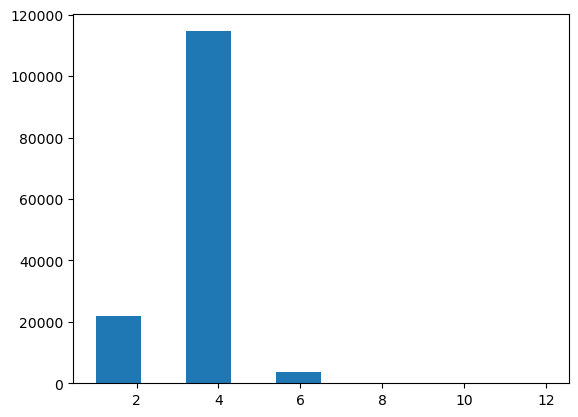

In [18]:
plt.hist(lengths)

In [19]:
np.unique(lengths, return_counts=True)

(array([ 1,  2,  4,  6,  8, 10, 12]),
 array([   603,  21319, 114590,   3683,    232,     12,      1]))

In [20]:
entity_begin_index = dataset.item_num+dataset.user_num
entity_begin_index

114438

One problem we still have is, that entities like artists, albums etc. are not included in the paths

In [21]:
for idx, arr in enumerate(flat_list):
    if np.any(arr > entity_begin_index):
        print(idx)

### Let's look at the most common entites

In [36]:
top_k_frequent_entites = dataset.item_num * 0.01
top_k_frequent_entites = int(np.round(top_k_frequent_entites))

Remove paths with just one or two elements

In [37]:
len(flat_list[0])

2

In [38]:
flat_list_cleaned = list(filter(lambda x: len(x) > 2, flat_list))

In [39]:
len(flat_list_cleaned) - len(flat_list)

-21922

In [40]:
list_without_head_and_tail = []
for arr in flat_list_cleaned:
    new_arr = np.delete(arr, 0)
    new_arr = np.delete(new_arr, -1)
    list_without_head_and_tail.append(new_arr)

In [41]:
counts = {}
for arr in list_without_head_and_tail:
    for item in arr:
        if item in counts:
            counts[item] += 1
        else:
            counts[item] = 1

In [42]:
counts

{55149: 8,
 1899: 149,
 70670: 1,
 3786: 271,
 14696: 254,
 8158: 122,
 22342: 23,
 5956: 64,
 11451: 37,
 51883: 3,
 1995: 6,
 7414: 24,
 33339: 14,
 10524: 59,
 19138: 22,
 2219: 292,
 14573: 96,
 12051: 5,
 30814: 4,
 5224: 13,
 18983: 19,
 2686: 53,
 51338: 74,
 667: 58,
 16071: 17,
 526: 1,
 24057: 13,
 999: 26,
 45778: 3,
 4500: 61,
 16116: 21,
 6617: 47,
 14419: 36,
 2370: 10,
 14534: 5,
 2974: 21,
 10374: 153,
 21034: 11,
 4228: 73,
 15285: 107,
 1233: 100,
 4192: 37,
 16122: 15,
 12227: 3,
 16304: 39,
 13467: 101,
 1945: 5,
 51948: 3,
 7763: 19,
 68319: 2,
 7041: 35,
 42196: 2,
 9429: 8,
 26674: 28,
 104: 197,
 15078: 51,
 4648: 94,
 16602: 1,
 630: 14,
 14634: 47,
 10859: 58,
 14421: 59,
 4063: 6,
 42446: 3,
 9831: 3,
 33378: 3,
 66: 75,
 20123: 12,
 1031: 66,
 32699: 6,
 257: 78,
 2900: 58,
 15528: 15,
 12638: 4,
 20383: 15,
 12235: 218,
 46929: 1,
 2471: 23,
 19316: 12,
 4082: 11,
 14491: 3097,
 4402: 19,
 62362: 4,
 8230: 23,
 15165: 190,
 43774: 2,
 4505: 34,
 38572: 2,
 

In [43]:
import heapq

In [44]:
k_keys_sorted_by_values = heapq.nlargest(top_k_frequent_entites, counts, key=counts.get)

In [45]:
for key in k_keys_sorted_by_values:
    rel_freq = 100 * counts[key] / len(flat_list_cleaned)
    print("%s - %s (%.2f%%)" % (key, counts[key], rel_freq))
    

14491 - 3097 (2.61%)
335 - 832 (0.70%)
14601 - 561 (0.47%)
523 - 493 (0.42%)
501 - 493 (0.42%)
6333 - 451 (0.38%)
3242 - 442 (0.37%)
75234 - 433 (0.37%)
9628 - 427 (0.36%)
14888 - 405 (0.34%)
4290 - 396 (0.33%)
14924 - 381 (0.32%)
14620 - 355 (0.30%)
74914 - 353 (0.30%)
7 - 352 (0.30%)
3150 - 332 (0.28%)
4632 - 330 (0.28%)
14571 - 306 (0.26%)
274 - 300 (0.25%)
15884 - 297 (0.25%)
1312 - 293 (0.25%)
2219 - 292 (0.25%)
13329 - 292 (0.25%)
82931 - 287 (0.24%)
327 - 282 (0.24%)
3786 - 271 (0.23%)
439 - 267 (0.23%)
14576 - 266 (0.22%)
1064 - 264 (0.22%)
1514 - 259 (0.22%)
6963 - 258 (0.22%)
1220 - 255 (0.22%)
14696 - 254 (0.21%)
212 - 254 (0.21%)
418 - 246 (0.21%)
16069 - 241 (0.20%)
2287 - 239 (0.20%)
357 - 237 (0.20%)
236 - 236 (0.20%)
2522 - 234 (0.20%)
9034 - 232 (0.20%)
14709 - 232 (0.20%)
1224 - 230 (0.19%)
2010 - 229 (0.19%)
4074 - 226 (0.19%)
925 - 226 (0.19%)
1342 - 223 (0.19%)
12235 - 218 (0.18%)
8036 - 208 (0.18%)
3751 - 205 (0.17%)
6764 - 199 (0.17%)
14787 - 198 (0.17%)
104 - 19

7220 - 57 (0.05%)
9162 - 57 (0.05%)
11095 - 57 (0.05%)
1446 - 57 (0.05%)
238 - 57 (0.05%)
118 - 57 (0.05%)
12342 - 57 (0.05%)
4834 - 56 (0.05%)
4493 - 56 (0.05%)
2157 - 56 (0.05%)
16030 - 56 (0.05%)
4170 - 56 (0.05%)
29319 - 56 (0.05%)
7815 - 56 (0.05%)
14563 - 56 (0.05%)
3585 - 56 (0.05%)
1807 - 56 (0.05%)
19232 - 56 (0.05%)
4096 - 56 (0.05%)
1910 - 56 (0.05%)
1340 - 55 (0.05%)
2886 - 55 (0.05%)
13486 - 55 (0.05%)
15345 - 55 (0.05%)
673 - 55 (0.05%)
2315 - 55 (0.05%)
2281 - 55 (0.05%)
31 - 55 (0.05%)
2862 - 55 (0.05%)
18011 - 55 (0.05%)
5489 - 55 (0.05%)
12443 - 55 (0.05%)
1576 - 55 (0.05%)
17076 - 55 (0.05%)
2328 - 55 (0.05%)
15987 - 55 (0.05%)
6111 - 55 (0.05%)
2725 - 55 (0.05%)
4371 - 54 (0.05%)
449 - 54 (0.05%)
5461 - 54 (0.05%)
6189 - 54 (0.05%)
1898 - 54 (0.05%)
577 - 54 (0.05%)
2779 - 54 (0.05%)
5831 - 54 (0.05%)
50697 - 54 (0.05%)
11988 - 54 (0.05%)
3272 - 54 (0.05%)
16112 - 54 (0.05%)
2686 - 53 (0.04%)
11077 - 53 (0.04%)
209 - 53 (0.04%)
1552 - 53 (0.04%)
4563 - 53 (0.04%)
11

17526 - 36 (0.03%)
7570 - 36 (0.03%)
13626 - 36 (0.03%)
6880 - 36 (0.03%)
2005 - 36 (0.03%)
244 - 36 (0.03%)
7039 - 36 (0.03%)
453 - 36 (0.03%)
306 - 36 (0.03%)
2606 - 36 (0.03%)
8930 - 36 (0.03%)
5368 - 36 (0.03%)
7641 - 36 (0.03%)
2365 - 36 (0.03%)
14494 - 36 (0.03%)
4287 - 36 (0.03%)
7391 - 36 (0.03%)
14625 - 36 (0.03%)
4359 - 36 (0.03%)
603 - 36 (0.03%)
5021 - 36 (0.03%)
6590 - 36 (0.03%)
4414 - 36 (0.03%)
896 - 36 (0.03%)
4787 - 36 (0.03%)
210 - 36 (0.03%)
2965 - 36 (0.03%)
15681 - 36 (0.03%)
13334 - 36 (0.03%)
6133 - 36 (0.03%)
6588 - 36 (0.03%)
6878 - 36 (0.03%)
3313 - 36 (0.03%)
5389 - 36 (0.03%)
18573 - 36 (0.03%)
2295 - 36 (0.03%)
16748 - 36 (0.03%)
6327 - 36 (0.03%)
1460 - 36 (0.03%)
17264 - 36 (0.03%)
7041 - 35 (0.03%)
15816 - 35 (0.03%)
15646 - 35 (0.03%)
4045 - 35 (0.03%)
2293 - 35 (0.03%)
2082 - 35 (0.03%)
1344 - 35 (0.03%)
1310 - 35 (0.03%)
9 - 35 (0.03%)
5725 - 35 (0.03%)
9128 - 35 (0.03%)
6533 - 35 (0.03%)
9627 - 35 (0.03%)
21503 - 35 (0.03%)
89387 - 35 (0.03%)
46747 

In [46]:
most_frequent_user = list(filter(lambda key: key < dataset.user_num , k_keys_sorted_by_values))
most_frequent_items = list(filter(lambda key: key >= dataset.user_num , k_keys_sorted_by_values))

In [66]:
user_ids = [int(item) for item in dataset.id2token(dataset.uid_field, most_frequent_user)]

In [67]:
user_ids

[68129,
 28533,
 35208,
 8114,
 14151,
 1519,
 9265,
 63290,
 5163,
 86924,
 55239,
 25719,
 107440,
 100438,
 56510,
 96919,
 111719,
 25011,
 1370,
 312,
 275,
 36343,
 24675,
 9156,
 49986,
 15095,
 15646,
 15694,
 14,
 46652,
 13230,
 65796,
 3141,
 2110,
 1715,
 53086,
 9556,
 43700,
 10958,
 64040,
 8584,
 52642,
 39259,
 67629,
 1439,
 68396,
 3641,
 4963,
 5226,
 1402,
 2635,
 46851,
 1257,
 104798,
 47134,
 5066,
 1273,
 20029,
 2334,
 47423,
 19778,
 724,
 15781,
 26054,
 38545,
 14569,
 28745,
 52297,
 2823,
 80411,
 21927,
 1778,
 7235,
 5664,
 22214,
 1152,
 1621,
 25051,
 76403,
 44718,
 61291,
 19652,
 27885,
 27611,
 26576,
 70263,
 55922,
 7534,
 7665,
 50960,
 48819,
 44967,
 40236,
 14507,
 65722,
 13583,
 64266,
 26494,
 638,
 6786,
 17823,
 7636,
 53872,
 32864,
 8963,
 63745,
 66931,
 20988,
 74737,
 409,
 45611,
 388,
 67640,
 62760,
 6212,
 12629,
 50741,
 91418,
 36911,
 34073,
 11737,
 70015,
 3018,
 19944,
 13541,
 11965,
 5204,
 7451,
 23016,
 51129,
 31476,

In [ ]:
dataset.user_num

In [53]:
dataset.token_like_fields

['entity_id',
 'user_id',
 'item_id',
 'timestamp',
 'head_id',
 'relation_id',
 'tail_id',
 'neg_item_id',
 'neg_tail_id']

### Load entity data

In [54]:
import pandas as pd

In [57]:
dataset_path = '10percent_subset'
user_path = 'data/lfm/%s_users.tsv' % dataset_path

In [63]:
users = pd.read_csv(user_path, sep='\t')
users.head()

,user_id,country,age,gender,creation_time
0,2,UK,35,m,2002-10-29 01:00:00
1,6,AT,28,n,2003-07-23 02:00:00
2,14,UK,48,m,2003-02-18 21:44:13
3,20,NaN,-1,n,2003-03-19 13:18:50
4,24,NaN,-1,n,2003-07-17 02:00:00


In [69]:
filtered_users_df = users[users['user_id'].isin(user_ids)]

In [72]:
filtered_users_df.groupby('gender').nunique()

,user_id,country,age,creation_time
gender,,,,
f,105,33,22,105
m,468,57,45,468
n,123,20,19,123


In [73]:
users.groupby('gender').nunique()

,user_id,country,age,creation_time
gender,,,,
f,2306,92,51,2306
m,9701,129,87,9701
n,2771,78,60,2771


In [ ]:
# TODO: Convert items and users to entites and evaluate gender, age, country, artist...

In [102]:
import networkx as nx
from path_tools import k_shortest_paths

In [83]:
nx_graph = nx.from_scipy_sparse_array(graph_matrix, create_using=nx.DiGraph)

In [84]:
type(nx_graph)

networkx.classes.digraph.DiGraph

In [113]:
paths = nx.shortest_simple_paths(nx_graph, 1, 14800)

In [114]:
def hasEntity(path: list):
    for item in path:
        if item > dataset.item_num + dataset.user_num:
            return True
        
    return False

In [ ]:
for idx, path in enumerate(paths):
    if hasEntity(path):
        print(path, idx)
        break